In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)
    # for filename in filenames:
    #     print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input
/kaggle/input/diabetic-retinopathy-224x224-grayscale-images
/kaggle/input/diabetic-retinopathy-224x224-grayscale-images/grayscale_images
/kaggle/input/diabetic-retinopathy-224x224-grayscale-images/grayscale_images/grayscale_images
/kaggle/input/diabetic-retinopathy-224x224-grayscale-images/grayscale_images/grayscale_images/Mild
/kaggle/input/diabetic-retinopathy-224x224-grayscale-images/grayscale_images/grayscale_images/Proliferate_DR
/kaggle/input/diabetic-retinopathy-224x224-grayscale-images/grayscale_images/grayscale_images/Moderate
/kaggle/input/diabetic-retinopathy-224x224-grayscale-images/grayscale_images/grayscale_images/No_DR
/kaggle/input/diabetic-retinopathy-224x224-grayscale-images/grayscale_images/grayscale_images/Severe
/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered
/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images
/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_f

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
import pandas as pd
import os
import shutil
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix,   ConfusionMatrixDisplay


def create_dataset():
    # Assuming images are in subfolders by severity level 
    categories = ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']
    splits=['train', 'val', 'test']
    train_ids, val_ids, test_ids = split_dataset(categories, splits=splits )

    # Data directories - Update these paths with your dataset location
    normal_dir = "/kaggle/input/diabetic-retinopathy-224x224-2019-data/colored_images"
    grayscale_dir = '/kaggle/input/diabetic-retinopathy-224x224-grayscale-images/grayscale_images/grayscale_images'
    gaussian_dir = '/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images'

    add_dataset(normal_dir, train_ids, val_ids, test_ids, None, categories)
    add_dataset(grayscale_dir, train_ids, val_ids, test_ids, "grayscale", categories)
    add_dataset(gaussian_dir, train_ids, val_ids, test_ids, "gaussian", categories)

    apply_transformations("dataset", categories, splits)

def split_dataset(categories, dataset_folder='dataset', splits=['train', 'val', 'test']):
    # Load CSV file into a DataFrame
    df = pd.read_csv('/kaggle/input/diabetic-retinopathy-224x224-2019-data/train.csv')
    print(df.head())
    id_column = df['id_code'].values  # Converts to a NumPy array
    y_column = df['diagnosis'].values

    train_ids = None
    val_ids = None
    test_ids = None
    # Split the IDs into training and testing sets
    if len(splits) == 3:
        train_ids, temp_ids = train_test_split(id_column, test_size=0.2, random_state=42, stratify=y_column)
        val_ids, test_ids= train_test_split(temp_ids, test_size=0.5, random_state=42)
        print("Train IDs:", len(train_ids))
        print("Val IDs", len(val_ids))
        print("Test IDs:", len(test_ids))
    elif len(splits) == 2:
        train_ids, test_ids = train_test_split(id_column, test_size=0.2, random_state=42, stratify=y_column)
        print("Train IDs:", len(train_ids))
        print("Test IDs:", len(test_ids))
    
    # Check if the folder exists
    if os.path.exists(dataset_folder):
        # Remove the folder and all its contents
        shutil.rmtree(dataset_folder)
        print(f"Folder '{dataset_folder}' and its contents have been removed.")
    else:
        print(f"The folder '{dataset_folder}' does not exist.")
        
    # Create directories for train/validation/test
    for split in splits:
        for category in categories:
            path = f'dataset/{split}/{category}'
            if not(os.path.exists(path) and os.path.isdir(path)):
                os.makedirs(path, exist_ok=True)

    return train_ids, val_ids, test_ids

def add_dataset(base_dir, train_ids, val_ids, test_ids, dataset_type, categories):
    for category in categories:
        # List all files in category folder
        images = os.listdir(os.path.join(base_dir, category))
        for img in images:
            img_id = img.split('.png')[0]
            split = None
            if train_ids and img_id in train_ids:
                split = "train"
            elif val_ids and img_id in val_ids:
                split = "val"
            elif test_ids and img_id in test_ids:
                split = "test"

            if dataset_type is not None:
                img_name = f"{img_id}-{dataset_type}.png"
            else:
                img_name = img

            if split is not None:
                shutil.copy(os.path.join(base_dir, category, img), f'dataset/{split}/{category}/{img_name}')


def apply_transformations(base_dir, categories, splits):
    print(categories)
    for split in splits:
        for category in categories:
            path = f'{base_dir}/{split}/{category}'
            print(path)
            images = os.listdir(path)
            for img in images:
                if img.find("-") == -1:
                    image_path = os.path.join(path, img)
                    # apply_canny_edge_detection(image_path, lower_threshold=30, upper_threshold=120)
                    apply_gamma_correction(image_path, gamma=2.2)




def train_model(train_dir, val_dir):
    # Parameters
    img_size = (224, 224)
    batch_size = 16
    epochs = 10
    fine_tune_epochs = 10

    # Create ImageDataGenerators for training and validation sets
    train_datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    val_datagen = ImageDataGenerator(rescale=1.0/255.0)

    # Create iterators
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    print(train_generator.samples, train_generator.samples // batch_size)
    print(val_generator.samples, val_generator.samples // batch_size)

    # Load the ResNet50 model with pre-trained ImageNet weights
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the base model layers to prevent updating during initial training
    base_model.trainable = False

    # # Add custom layers for DR classification
    # x = base_model.output
    # x = GlobalAveragePooling2D()(x)
    # x = Dense(1024, activation='relu')(x)
    # x = Dropout(0.5)(x)
    # output = Dense(5, activation='softmax')(x)  # 5 classes for DR severity

    # # Create the final model
    # model = Model(inputs=base_model.input, outputs=output)

    # # Compile the model
    # model.compile(optimizer=Adam(learning_rate=0.001),
    #             loss='categorical_crossentropy',
    #             metrics=['accuracy'])

    # Add custom layers for DR classification with L2 regularization
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024,activation='relu', kernel_regularizer=l2(0.01))(x) # L2 regularization applied
    x = BatchNormalization()(x)  # Batch Normalization
    x = tf.keras.layers.Activation('relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(5, activation='softmax', kernel_regularizer=l2(0.01))(x)  # L2 regularization applied

    
    # Create the final model
    model = Model(inputs=base_model.input, outputs=output)
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',  # For multi-class classification
              metrics=['accuracy'])

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=max(1,train_generator.samples // batch_size),
        validation_data=val_generator,
        validation_steps=max(1,val_generator.samples // batch_size),
        epochs=epochs
    )

    plot_training_history(history)

    # Fine-Tuning - Unfreeze the base model layers
    base_model.trainable = True

    # Recompile the model with a lower learning rate
    model.compile(optimizer=Adam(learning_rate=1e-5),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    # Fine-tune the model
    history_fine = model.fit(
        train_generator,
        steps_per_epoch=max(1,train_generator.samples // batch_size),
        validation_data=val_generator,
        validation_steps=max(1,val_generator.samples // batch_size),
        epochs=fine_tune_epochs
    )

    plot_training_history(history_fine)

    # Evaluate the model on the validation set
    val_loss, val_accuracy = model.evaluate(val_generator, steps=val_generator.samples // batch_size)
    print(f'Validation accuracy: {val_accuracy:.4f}')

    # Save the trained model
    model.save('dr_classification_model.h5')
    print("Model saved as 'dr_classification_model.h5'")

    return model


def train_model_cross_validation(train_dir, val_dir):

    # Combine train and validation data
    train_paths, train_labels = collect_image_paths_and_labels(train_dir)
    val_paths, val_labels = collect_image_paths_and_labels(val_dir)
    
    # Merge train and validation datasets
    all_paths = train_paths + val_paths
    all_labels = train_labels + val_labels
    
    # Convert to numpy array for easier manipulation
    all_paths = np.array(all_paths)
    all_labels = np.array(all_labels)
    
    print(len(all_paths))
    print(len(all_labels))

     # Parameters
    img_size = (224, 224)
    batch_size = 16
    epochs = 10
    fine_tune_epochs = 10
    
    # Set number of folds
    k_folds = 5
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    best_accuracy = 0
    best_model_path = 'best_model.h5'
    histories=[]

    # Create ImageDataGenerators for training and validation sets
    train_datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    val_datagen = ImageDataGenerator(rescale=1.0/255.0)

    # Iterate over each fold
    fold_number = 1
    for train_index, val_index in kf.split(all_paths):
        print(f"Training fold {fold_number}/{k_folds}...")
    
        # Split data for the current fold
        train_paths_fold = all_paths[train_index]
        train_labels_fold = all_labels[train_index]
        val_paths_fold = all_paths[val_index]
        val_labels_fold = all_labels[val_index]
    
        # Create Pandas DataFrame for flow_from_dataframe
        train_df = pd.DataFrame({'filename': train_paths_fold, 'class': train_labels_fold})
        val_df = pd.DataFrame({'filename': val_paths_fold, 'class': val_labels_fold})

        # Create generators
        train_generator = train_datagen.flow_from_dataframe(
            train_df,
            x_col='filename',
            y_col='class',
            target_size=img_size,
            class_mode='categorical',
            batch_size=batch_size
        )
    
        val_generator = val_datagen.flow_from_dataframe(
            val_df,
            x_col='filename',
            y_col='class',
            target_size=img_size,
            class_mode='categorical',
            batch_size=batch_size
        )

         # Define your model
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        base_model.trainable = False  # Freeze base model
    
        # Add custom layers for DR classification with L2 regularization
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(1024,activation='relu', kernel_regularizer=l2(0.01))(x) # L2 regularization applied
        x = BatchNormalization()(x)  # Batch Normalization
        x = tf.keras.layers.Activation('relu')(x)
        x = Dropout(0.5)(x)
        output = Dense(5, activation='softmax', kernel_regularizer=l2(0.01))(x)  # L2 regularization applied
    
        
        # Create the final model
        model = Model(inputs=base_model.input, outputs=output)
        
        # Compile the model
        model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',  # For multi-class classification
                  metrics=['accuracy'])
    
        # Train the model
        history = model.fit(
            train_generator,
            steps_per_epoch=max(1,train_generator.samples // batch_size),
            validation_data=val_generator,
            validation_steps=max(1,val_generator.samples // batch_size),
            epochs=epochs
        )

        # Fine-Tuning - Unfreeze the base model layers
        base_model.trainable = True
    
        # Recompile the model with a lower learning rate
        model.compile(optimizer=Adam(learning_rate=1e-5),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
    
        # Fine-tune the model
        history_fine = model.fit(
            train_generator,
            steps_per_epoch=max(1,train_generator.samples // batch_size),
            validation_data=val_generator,
            validation_steps=max(1,val_generator.samples // batch_size),
            epochs=fine_tune_epochs
        )
    

        # Evaluate the model on the validation set
        val_loss, val_accuracy = model.evaluate(val_generator, steps=val_generator.samples // batch_size)
        print(f'Validation accuracy: {val_accuracy:.4f}')

        # Save history for learning curve
        histories.append(history_fine.history)

    
        # Increment fold counter
        fold_number += 1

        # Save the model if it's the best so far
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            model.save(best_model_path)  # Save the best model

    # Compute average accuracy and loss across folds
    avg_train_accuracy = np.mean([history['accuracy'] for history in
    histories], axis=0)
    avg_val_accuracy = np.mean([history['val_accuracy'] for history in
    histories], axis=0)
    avg_train_loss = np.mean([history['loss'] for history in histories],
    axis=0)
    avg_val_loss = np.mean([history['val_loss'] for history in histories],
    axis=0)
    # Plot average learning curves
    plt.figure(figsize=(12, 5))
    plt.plot(avg_train_accuracy, label='Average Training Accuracy')
    plt.plot(avg_val_accuracy, label='Average Validation Accuracy')
    plt.title("Learning Curve: Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
    plt.figure(figsize=(12, 5))
    plt.plot(avg_train_loss, label='Average Training Loss')
    plt.plot(avg_val_loss, label='Average Validation Loss')
    plt.title("Learning Curve: Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()




def test_model(model_name, test_dir):

    model = load_model(model_name)
    print(model.summary())

    # Create the test data generator with only rescaling
    test_datagen = ImageDataGenerator(rescale=1.0/255.0)

    # Create the test generator
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=False  # No shuffling for evaluation
    )

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // 32)
    print(f'Test accuracy: {test_accuracy:.4f}')
    print(f'Test loss: {test_loss:.4f}')

    # Test the final model on the test set
    test_predictions = model.predict(test_generator)

    # Get the predicted class indices (if using softmax output)
    predicted_classes = test_predictions.argmax(axis=1)  # Returns index of the highest probability
    
    # Retrieve true labels from the test generator
    y_test = test_generator.classes  # Ground truth labels from the generator
    class_indices = test_generator.class_indices  # Get the class indices mapping

    # Create a reverse mapping from indices to class names
    class_labels = {v: k for k, v in class_indices.items()}

    # # Calculate and print accuracy on test set
    # test_accuracy = accuracy_score(y_test, predicted_classes)
    # print(f"Test Accuracy: {test_accuracy:.4f}")
    
    # Confusion Matrix
    # Compute the confusion matrix
    cm = confusion_matrix(y_test, predicted_classes)
    
    # Display the confusion matrix using ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_labels.values()))
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()



def apply_canny_edge_detection(image_path, lower_threshold=30, upper_threshold=120):
    # Read the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Apply Canny edge detection
    edges = cv2.Canny(image, lower_threshold, upper_threshold)
    
    # Save the result to a new file
    cv2.imwrite(f"{image_path.split('.png')[0]}-edge.png", edges)

    return edges

    


def apply_gamma_correction(image_path, gamma):
    # Read the image
    image = cv2.imread(image_path)
    
    # Normalize the image to range [0, 1]
    normalized_image = image / 255.0
    
    # Apply gamma correction: I_output = I_input ^ gamma
    gamma_corrected = np.power(normalized_image, gamma)
    
    # Scale back to range [0, 255] and convert to 8-bit unsigned integers
    gamma_corrected = np.uint8(gamma_corrected * 255)

    cv2.imwrite(f"{image_path.split('.png')[0]}-gamma.png", gamma_corrected)
    
    return gamma_corrected


def apply_gaussian_filter(image_path, ksize=(5, 5), sigmaX=0):
    # Read the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Apply Gaussian Blur
    blurred_image = cv2.GaussianBlur(image, ksize, sigmaX)
    
    # Save the result to a new file
    cv2.imwrite(f"{image_path.split('.png')[0]}-gaussian.png", blurred_image)

    return blurred_image

def apply_high_pass_filter(image_path, ksize=(5, 5), sigmaX=8):
    # Read the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Apply Gaussian Blur to create a smoothed version of the image
    blurred_image = cv2.GaussianBlur(image, ksize, sigmaX)
    
    # Subtract the blurred image from the original image
    high_pass = cv2.subtract(image, blurred_image)
    
    # Optionally, enhance the effect by adding it back to the original
    enhanced_image = cv2.addWeighted(image, 0.5, high_pass, 0.5, 0)
    
    # Save the result to a new file
    cv2.imwrite(f"{image_path.split('.png')[0]}-highpass.png", enhanced_image)
    
    return enhanced_image

# Plot the training history to see if there's overfitting
def plot_training_history(history):
    # Retrieve metrics from the history object
    epochs = range(1, len(history.history['loss']) + 1)
    
    # Plot Training & Validation Loss
    plt.figure(figsize=(14, 5))
    
    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss', marker='o')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Training & Validation Accuracy if available
    if 'accuracy' in history.history:
        # Accuracy Plot
        plt.subplot(1, 2, 2)
        plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', marker='o')
        plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', marker='o')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

# Collect image file paths and labels from train and validation folders
def collect_image_paths_and_labels(folder):
    image_paths = []
    labels = []
    for class_name in os.listdir(folder):
        class_path = os.path.join(folder, class_name)
        if os.path.isdir(class_path):
            for image_file in os.listdir(class_path):
                image_paths.append(os.path.join(class_path, image_file))
                labels.append(class_name)
    return image_paths, labels

In [14]:
# Data directories - Update these paths with your dataset location
train_dir = '/kaggle/working/dataset/train'
val_dir = '/kaggle/working/dataset/val'
test_dir = '/kaggle/working/dataset/test'

In [ ]:
create_dataset()

In [ ]:
train_model_cross_validation(train_dir, val_dir)




Found 11716 images belonging to 5 classes.
Found 1464 images belonging to 5 classes.
11716 732
1464 91
Epoch 1/10
732/732 ━━━━━━━━━━━━━━━━━━━━ 196s 249ms/step - accuracy: 0.5707 - loss: 2.7057 - val_accuracy: 0.4801 - val_loss: 8.1211
Epoch 2/10
732/732 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8125 - loss: 0.9322 - val_accuracy: 0.1250 - val_loss: 13.7395
Epoch 3/10
732/732 ━━━━━━━━━━━━━━━━━━━━ 178s 240ms/step - accuracy: 0.5920 - loss: 1.2142 - val_accuracy: 0.4794 - val_loss: 7.0329
Epoch 4/10
732/732 ━━━━━━━━━━━━━━━━━━━━ 0s 66us/step - accuracy: 0.7500 - loss: 1.0229 - val_accuracy: 0.2500 - val_loss: 9.8902
Epoch 5/10
732/732 ━━━━━━━━━━━━━━━━━━━━ 175s 237ms/step - accuracy: 0.6011 - loss: 1.1844 - val_accuracy: 0.5096 - val_loss: 2.4096
Epoch 6/10
732/732 ━━━━━━━━━━━━━━━━━━━━ 0s 65us/step - accuracy: 0.6875 - loss: 1.0613 - val_accuracy: 0.3750 - val_loss: 2.4058
Epoch 7/10
732/732 ━━━━━━━━━━━━━━━━━━━━ 176s 238ms/step - accuracy: 0.5958 - loss: 1.1768 - val_accuracy: 0.4766 -

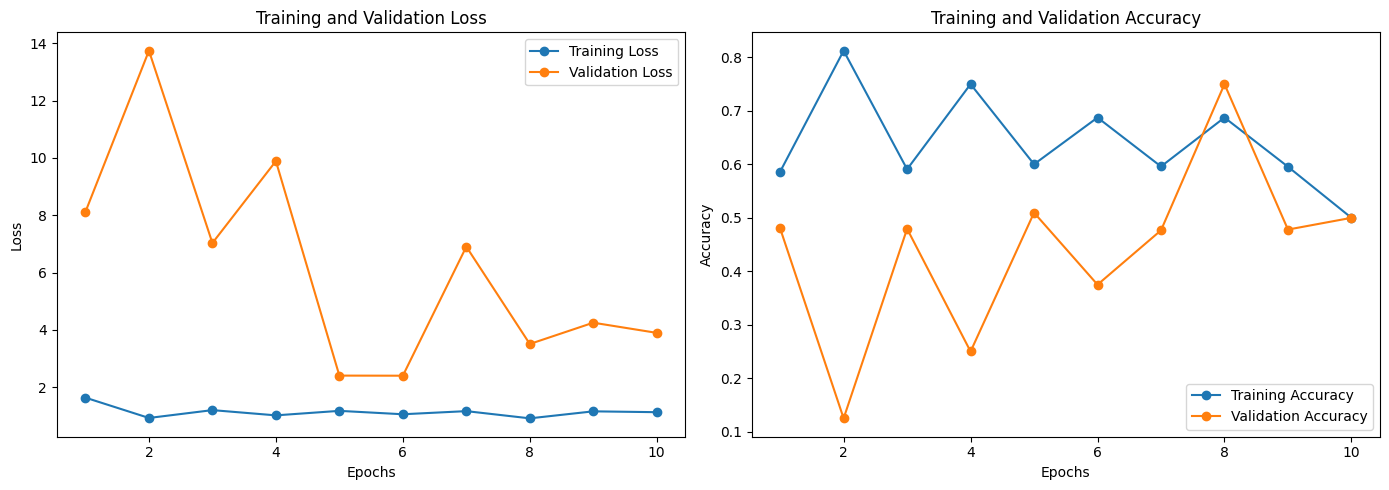

Epoch 1/10
198/732 ━━━━━━━━━━━━━━━━━━━━ 3:00 339ms/step - accuracy: 0.5965 - loss: 1.2804

I0000 00:00:1731638455.361329      72 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_48', 168 bytes spill stores, 168 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion', 28 bytes spill stores, 28 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_22', 20 bytes spill stores, 20 bytes spill loads



732/732 ━━━━━━━━━━━━━━━━━━━━ 260s 277ms/step - accuracy: 0.6647 - loss: 1.0569 - val_accuracy: 0.5014 - val_loss: 3.6262
Epoch 2/10
732/732 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8750 - loss: 0.5305 - val_accuracy: 0.5000 - val_loss: 4.7199
Epoch 3/10
732/732 ━━━━━━━━━━━━━━━━━━━━ 181s 244ms/step - accuracy: 0.7382 - loss: 0.7705 - val_accuracy: 0.7328 - val_loss: 0.7930
Epoch 4/10
732/732 ━━━━━━━━━━━━━━━━━━━━ 0s 71us/step - accuracy: 0.6875 - loss: 0.7174 - val_accuracy: 0.7500 - val_loss: 0.7860
Epoch 5/10
732/732 ━━━━━━━━━━━━━━━━━━━━ 179s 243ms/step - accuracy: 0.7654 - loss: 0.6980 - val_accuracy: 0.7397 - val_loss: 0.7789
Epoch 6/10
732/732 ━━━━━━━━━━━━━━━━━━━━ 0s 67us/step - accuracy: 0.7500 - loss: 0.6201 - val_accuracy: 0.8750 - val_loss: 0.7764
Epoch 7/10
732/732 ━━━━━━━━━━━━━━━━━━━━ 182s 246ms/step - accuracy: 0.7755 - loss: 0.6572 - val_accuracy: 0.7576 - val_loss: 0.7409
Epoch 8/10
732/732 ━━━━━━━━━━━━━━━━━━━━ 0s 66us/step - accuracy: 1.0000 - loss: 0.4104 - val_accu

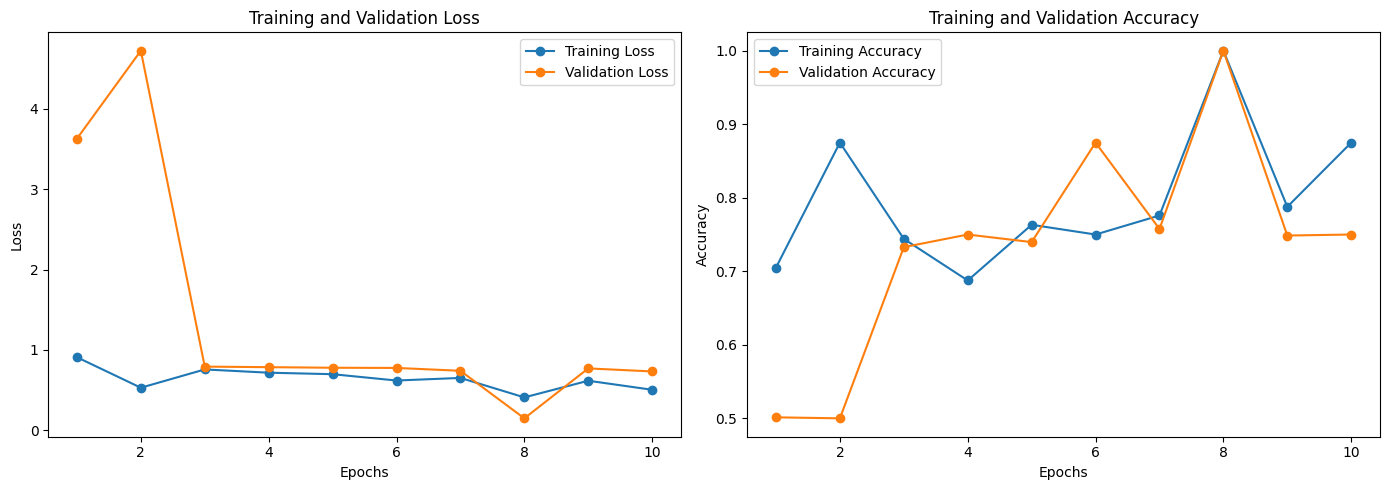

91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.7387 - loss: 0.8217
Validation accuracy: 0.7479
Model saved as 'dr_classification_model.h5'


In [ ]:
model = train_model(train_dir, val_dir)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,695,111 (98.02 MB)

 Trainable params: 25,639,941 (97.81 MB)

 Non-trainable params: 55,168 (215.50 KB)

 Optimizer params: 2 (12.00 B)

None
Found 1468 images belonging to 5 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.8048 - loss: 0.7332
Test accuracy: 0.7951
Test loss: 0.6425
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step


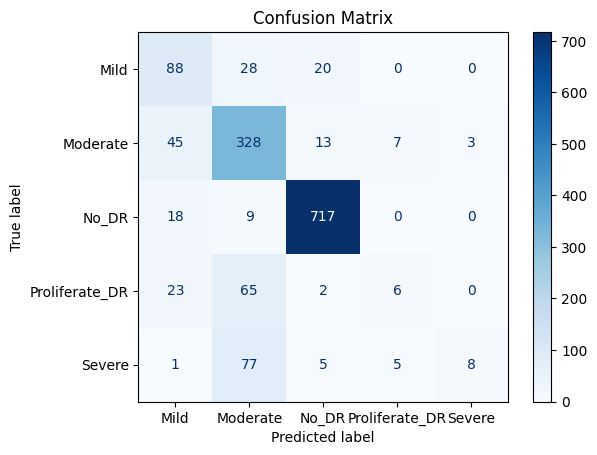

In [2]:
model_file = "best_model.h5"
test_model(model_file, test_dir)

In [1]:
import os
import subprocess
from IPython.display import FileLink, display

def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))

download_file('/kaggle/working/best_model.h5', 'dr_classification_model_79_51.h5')

/kaggle/working/dr_classification_model_79_51.h5.zip